# Import

In [3]:
#!/opt/conda/bin/python3

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter  # TensorBoard import
import numpy as np
from scipy.signal import sawtooth
import matplotlib.pyplot as plt

# Define the LSTM model for actuator identification

In [4]:
class ActuatorLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        """
        Initialize the LSTM model.
        :param input_size: Number of input features (joint position, velocity, time)
        :param hidden_size: Number of units in the LSTM hidden layer
        :param num_layers: Number of LSTM layers
        :param output_size: Number of output features (torque, temperature)
        """
        super(ActuatorLSTM, self).__init__()
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define a fully connected (dense) layer to map LSTM outputs to desired outputs
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass through the network.
        :param x: Input sequence with shape (batch_size, seq_len, input_size)
        :return: Predicted torque and temperature with shape (batch_size, seq_len, output_size)
        """

        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))  # LSTM output
        out = self.fc(out)     # Fully connected layer (last timestep)
        return out

# Hyperparameters

In [5]:
input_size = 3          # e.g., position, velocity, time
hidden_size = 50
output_size = 2         # e.g., torque and temperature
num_layers = 2
learning_rate = 0.001
num_epochs = 2000
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Generate synthetic input data

In [6]:
num_samples = 1000  # Total number of sequences
seq_length = 100     # Length of each sequence
frequency = 1       # Frequency for the sine wave
sampling_rate = 100  # Sampling rate for the signals

# Time vector for one sequence
t = np.linspace(0, seq_length / sampling_rate, seq_length)
# Prepare tensors for the input and output
x_samples = np.zeros((num_samples, seq_length, input_size))
y_samples = np.zeros((num_samples, seq_length, output_size))
for i in range(num_samples):
    # Generate signals for each sequence
    position = np.sin(2 * np.pi * frequency * t)  # Sine wave for position
    velocity = np.cos(2 * np.pi * frequency * t)  # Cosine wave for velocity (derivative)
    output = sawtooth(2 * np.pi * 10 * frequency * t)  # Sawtooth wave for output

    # Fill input tensor
    x_samples[i, :, 0] = position + 0.1 * np.random.randn(seq_length)  # Position with noise
    x_samples[i, :, 1] = velocity + 0.1 * np.random.randn(seq_length)  # Velocity with noise
    x_samples[i, :, 2] = t  # Time as a feature

    # Fill output tensor
    y_samples[i, :, 0] = output + 0.1 * np.random.randn(seq_length)  # Output with noise

# Plot a few position signals to visualize them
plt.figure(figsize=(12, 6))

# Choose how many signals to plot for clarity
# num_to_plot = 10  # Number of samples to visualize
# for i in range(num_to_plot):
#     plt.plot(t, y_samples[i,:,1], label=f'Sample {i+1}', alpha=0.6)  # Plotting position (first feature)

# plt.title('Sinusoidal Position Signals for Samples')
# plt.xlabel('Time')
# plt.ylabel('Position Value')
# plt.xlim(0, 1)  # Set x-axis limits to cover the time range
# plt.ylim(-1.5, 1.5)  # Set y-axis limits to fit the sine wave
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()
# Convert to PyTorch tensors
x_samples_tensor = torch.tensor(x_samples, dtype=torch.float32).to(device)
y_samples_tensor = torch.tensor(y_samples, dtype=torch.float32).to(device)

# Check tensor sizes
print("x_samples_tensor shape:", x_samples_tensor.shape)
print("y_samples_tensor shape:", y_samples_tensor.shape)

x_samples_tensor shape: torch.Size([1000, 100, 3])
y_samples_tensor shape: torch.Size([1000, 100, 2])


<Figure size 864x432 with 0 Axes>

# Generate synthetic input data

In [7]:
model = ActuatorLSTM(input_size, hidden_size, output_size, num_layers).to('cuda')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
writer = SummaryWriter(log_dir='./runs/actuator_lstm')  # TensorBoard writer

2024-11-06 14:52:40.914384: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 14:52:41.126092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Example input data (batch_size=16, sequence_length=10, input_size=3). Here, batch_size is the number of samples in a batch seq_len is the length of the time sequence fed to the LSTM. Sample dataset (replace x_samples and y_samples with your actual data)

In [8]:
# x_samples = torch.rand((1000, 10, input_size))  # e.g., 1000 sequences of length 10
# y_samples = torch.rand((1000, output_size))     # Target outputs
dataset = TensorDataset(x_samples_tensor, y_samples_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Forward pass

In [ ]:
#output = model(x_sample)
#print("Output shape:", output.shape)  # Should be (batch_size, sequence_length, output_size)

# Training loop

In [9]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i, (x_batch, y_batch) in enumerate(dataloader):
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    # Calculate average loss and log it to TensorBoard
    avg_loss = epoch_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    writer.add_scalar('Loss/train', avg_loss, epoch)  # Log to TensorBoard
    
    # Extract individual outputs for logging
    torque_output = outputs[:, 0].detach().mean().item()  # First output
    temperature_output = outputs[:, 1].detach().mean().item()  # Second output
    
    # Log loss and output values to TensorBoard
    writer.add_scalar('Loss/train', loss.item(), epoch)
    writer.add_scalar('Output/torque', torque_output, epoch)
    writer.add_scalar('Output/temperature', temperature_output, epoch)
    
    # Save model checkpoints every 10 epochs
    if (epoch + 1) % 250 == 0:
        torch.save(model.state_dict(), f'./checkpoints/actuator_lstm_epoch_{epoch+1}.pth')

# Close the TensorBoard writer
writer.close()
print("Training complete.")

Epoch [1/2000], Loss: 0.1740
Epoch [2/2000], Loss: 0.1703
Epoch [3/2000], Loss: 0.1508
Epoch [4/2000], Loss: 0.0691
Epoch [5/2000], Loss: 0.0534
Epoch [6/2000], Loss: 0.0407
Epoch [7/2000], Loss: 0.0316
Epoch [8/2000], Loss: 0.0303
Epoch [9/2000], Loss: 0.0236
Epoch [10/2000], Loss: 0.0165
Epoch [11/2000], Loss: 0.0307
Epoch [12/2000], Loss: 0.0160
Epoch [13/2000], Loss: 0.0100
Epoch [14/2000], Loss: 0.0086
Epoch [15/2000], Loss: 0.0077
Epoch [16/2000], Loss: 0.0072
Epoch [17/2000], Loss: 0.0068
Epoch [18/2000], Loss: 0.0065
Epoch [19/2000], Loss: 0.0063
Epoch [20/2000], Loss: 0.0062
Epoch [21/2000], Loss: 0.0060
Epoch [22/2000], Loss: 0.0060
Epoch [23/2000], Loss: 0.0059
Epoch [24/2000], Loss: 0.0058
Epoch [25/2000], Loss: 0.0058
Epoch [26/2000], Loss: 0.0057
Epoch [27/2000], Loss: 0.0057
Epoch [28/2000], Loss: 0.0056
Epoch [29/2000], Loss: 0.0055
Epoch [30/2000], Loss: 0.0055
Epoch [31/2000], Loss: 0.0055
Epoch [32/2000], Loss: 0.0055
Epoch [33/2000], Loss: 0.0054
Epoch [34/2000], Lo

In [20]:
# Now we perform inference with the same input data
model.eval()  # Set the model to evaluation mode

# Get the model's output for the training input data
with torch.no_grad():  # No gradient computation needed
    predictions = model(x_samples_tensor)

# Convert predictions to NumPy for plotting
predictions_np = predictions.cpu().numpy()
print(predictions_np.shape)

(1000, 100, 2)


1000


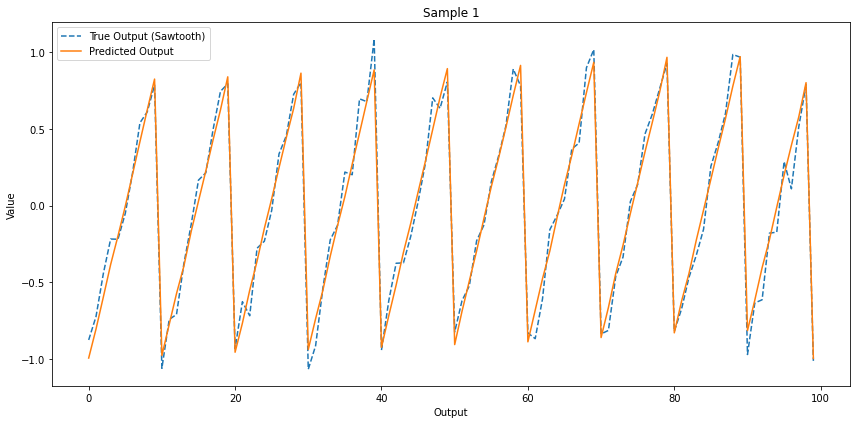

In [21]:

# Visualize the results
plt.figure(figsize=(12, 6))
print(len(y_samples))
for i in range(1):  # Compare a few samples
    plt.plot(y_samples[i, :, 0], label='True Output (Sawtooth)', linestyle='--')
    plt.plot(predictions_np[i, :, 0], label='Predicted Output', linestyle='-')
    plt.title(f'Sample {i + 1}')
    plt.xlabel('Output')
    plt.ylabel('Value')
    plt.legend()

# plt.plot(x_samples[:,1,1], label='True Output (Sawtooth)', linestyle='--')
# plt.plot(predictions_np[:,1], label='Predicted Output', linestyle='-')

plt.tight_layout()
plt.show()